실행 예시
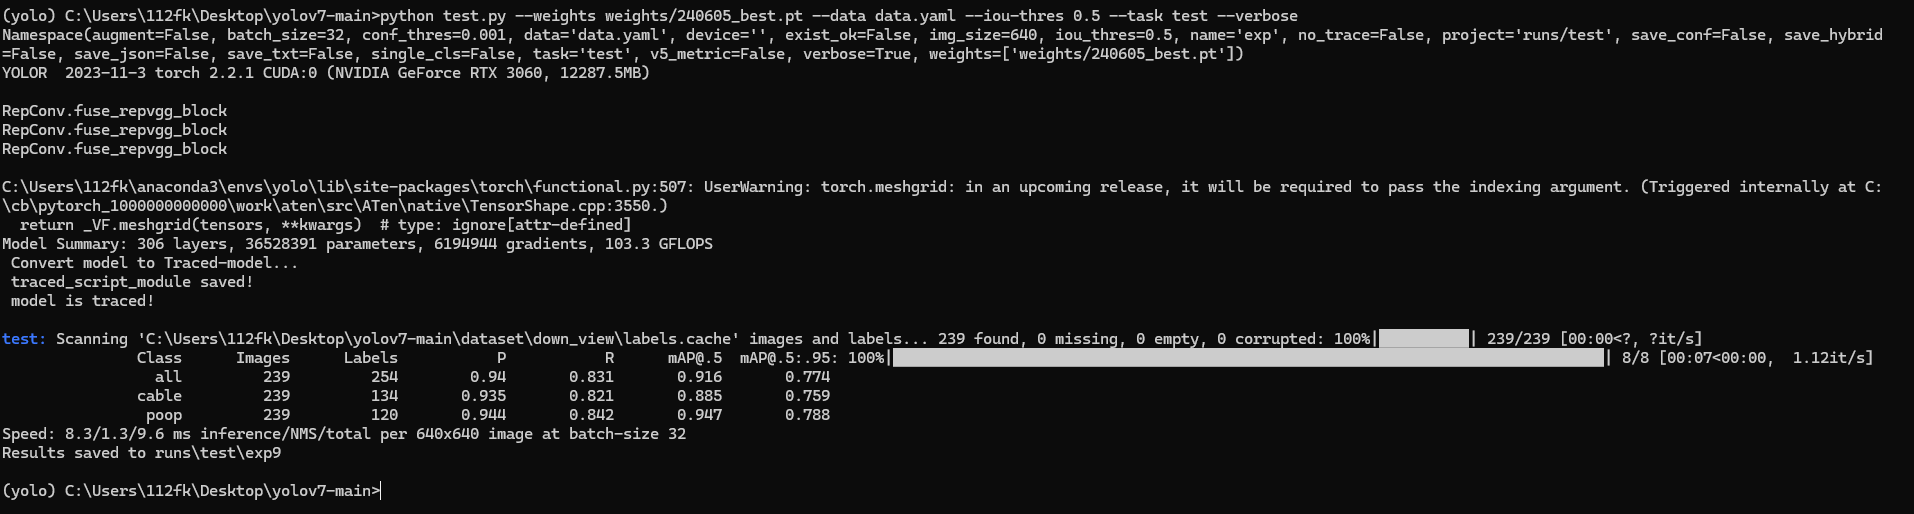

# 증강 없이 진행

In [2]:
# 데이터셋 경로에 따른 data.yaml 만드는 함수
def make_yaml(view):
    txt = f'''
    
test: D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/{view}/images

# number of classes
nc: 7

# class names
names: ['cable', 'carpet', 'cloths', 'liquid', 'poop', 'rack', 'scale']
'''
    with open('data.yaml', 'w') as f:
        f.write(txt)

up 뷰 테스트

In [5]:
make_yaml('up_view')
!python test.py --weights weights/240612_best.pt --data data.yaml --iou-thres 0.5 --task test --verbose --save-txt

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.5, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='test', v5_metric=False, verbose=True, weights=['weights/240612_best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

                 all         975         978       0.668       0.492        0.52       0.437
               cable         975         120       0.657       0.483       0.524       0.418
              carpet         975         160       0.936      0.0913       0.238       0.233
              cloths         975         120       0.575       0.383       0.446       0.423
              liquid         975         178       0.351       0.876       0.834       0.669
       

YOLOR  830ca53 torch 2.2.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287.5MB)

c:\Users\112fk\anaconda3\envs\yolo\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 306 layers, 36512236 parameters, 6194944 gradients, 103.3 GFLOPS

test: Scanning 'D:\Code\240321_MovingPlatformObjectDetection\RealSense_YOLO_package\yolov7-main\dataset\240612_origin_data_merge\up_view\labels.cache' images and labels... 975 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 975/975 [00:00<?, ?it/s]
test: Scanning 'D:\Code\240321_MovingPlatformObjectDetection\RealSense_YOLO_package\yolov7-main\dataset\240612_origin_data_merge\up_view\labels.cache' images and labels... 975 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 9

down 뷰 테스트

In [4]:
make_yaml('down_view')
!python test.py --weights weights/240612_best.pt --data data.yaml --iou-thres 0.5 --task test --verbose --save-txt

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.5, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='test', v5_metric=False, verbose=True, weights=['weights/240612_best.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

                 all         999        1023       0.864        0.81       0.893       0.741
               cable         999         134        0.98       0.749       0.896       0.772
              carpet         999         160       0.975       0.718       0.912       0.832
              cloths         999         129        0.73       0.845       0.865       0.773
              liquid         999         200        0.85       0.965        0.97       0.776
       

YOLOR  830ca53 torch 2.2.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287.5MB)

c:\Users\112fk\anaconda3\envs\yolo\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 306 layers, 36512236 parameters, 6194944 gradients, 103.3 GFLOPS

Scanning images:   0%|          | 0/999 [00:00<?, ?it/s]
test: Scanning 'D:\Code\240321_MovingPlatformObjectDetection\RealSense_YOLO_package\yolov7-main\dataset\240612_origin_data_merge\down_view\labels' images and labels... 3 found, 0 missing, 0 empty, 0 corrupted:   0%|          | 3/999 [00:00<00:34, 29.23it/s]
test: Scanning 'D:\Code\240321_MovingPlatformObjectDetection\RealSense_YOLO_package\yolov7-main\dataset\240612_origin_data_merge\down_view\labels' images and labels... 7 found, 

# 데이터 증강

In [141]:
import os
import cv2
import albumentations as A
from random import randint, random
from tqdm import tqdm
import time
import shutil

class Img_aug:
    def __init__(self):
        self.bbox_params = A.BboxParams(format='yolo')
        self.spent_time = 0

    def auto_augment(self, dataset_path, repeat=1):
        '''
        dataset 경로를 넣으면 자동으로 증강됨
        
        dataset_path: YOLO형식의 train, val, test가 존재하는 폴더(test는 꼭 있을 필요 없음)
        반드시 지켜져야 하는 파일 경로 형식
        데이터셋 폴더
          ㄴ train
          ㄴ val
          ㄴ test
          (train, val, test 중 하나 이상만 존재하면 되지만, 꼭 폴더가 있어야 함)
        repeat: 데이터셋을 증강할 횟수. 1로 설정할 경우 원본 + 증강 1번에 대한 데이터셋이 새로 저장됨
        '''
        repeat += 1 # 처음은 자기 자신 복사
        # 증강 폴더 및 경로 생성
        aug_path = f'{dataset_path}_aug'
        # 증강 전체 flow 시작
        folder_list = os.listdir(dataset_path)
        for aug_cnt in range(repeat):
            for mode in ['train', 'val', 'test']:
                if not mode in folder_list: 
                    print(f'{mode} 폴더 없음. 다음 폴더 진행')
                    continue # 폴더가 없으면 패스
                # 폴더 생성
                for data in ['images', 'labels']:
                    os.makedirs(f'{aug_path}/{mode}/{data}', exist_ok=True)
                # 이미지 리스트 불러오기
                for img_name in tqdm(os.listdir(f'{dataset_path}/{mode}/images'), desc=mode):
                    label_name = f'{img_name.split(".")[0]}.txt'
                    # 필요 경로 설정
                    r_img_path = f'{dataset_path}/{mode}/images/{img_name}'
                    r_label_path = f'{dataset_path}/{mode}/labels/{label_name}'
                    # 처음에는 자기 자신 복사하기
                    if aug_cnt == 0:
                        w_img_path = f'{aug_path}/{mode}/images/{img_name}'
                        w_label_path = f'{aug_path}/{mode}/labels/{label_name}'
                        # 원본 이미지, 레이블 복사
                        try: shutil.copy(r_img_path, w_img_path)
                        except: print(f'원본 이미지 복사 에러 발생: {r_img_path}')
                        try: shutil.copy(r_label_path, w_label_path)
                        except: print(f'원본 레이블 복사 에러 발생: {r_label_path}')
                    # 증강 시작
                    else:
                        # path 정의하기
                        name_without_format = img_name.split('.')[0]
                        aug_img_name = f'{name_without_format}_aug{aug_cnt}.png'
                        aug_label_name = f'{name_without_format}_aug{aug_cnt}.txt'
                        w_img_path = f'{aug_path}/{mode}/images/{aug_img_name}'
                        w_label_path = f'{aug_path}/{mode}/labels/{aug_label_name}'
                        # 증강
                        self.img_aug(r_img_path, r_label_path, w_img_path, w_label_path)
        

    def img_aug(self, r_img_path, r_label_path, w_img_path, w_label_path):
        '''
        YOLO형식의 img, label path를 입력받아 증강 후 원하는 path에 저장해준다.
        알고리즘 진행 순서:
        1. 고화질 이미지, 레이블 읽어오기
        2. random crop 진행(bbox를 해치지 않는 선에서)
        3. 나머지 빠른 증강을 위해 작은 이미지로 resize(640)
        4. 나머지 증강 효과 적용
        5. 저장

        r_img_path: 읽어오는 이미지 경로
        r_label_path: 읽어오는 레이블 경로
        w_img_path: 쓰고싶은 이미지 경로
        w_label_path: 쓰고싶은 레이블 경로
        '''
        start_time = time.time()
        # 이미지, 레이블 읽어오기
        img = cv2.imread(r_img_path)
        bboxes = self.txt_to_bbox(r_label_path)

        # bbox를 해치지 않는 선에서 random crop 진행(resize 병행)
        img, bboxes = self.random_crop(img, bboxes, p=0.5)

        # 화질 적당하기 줄이기
        img = self.resize(img)

        # 나머지 증강 옵션 설정
        transform = A.Compose([
            A.HorizontalFlip(p=0.5), # 이미지 랜덤 호리젠탈 플립
            A.Rotate(limit=20, p=0.5), # 이미지 회전 (-n도부터 n도 사이에서 무작위로 선택)
            A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.15, p=0.5),# 이미지의 색상 변화
            A.GaussianBlur(blur_limit=(3, 7), p=0.5), # 이미지에 가우시안 블러 적용
            A.MotionBlur(blur_limit=(3, 7), p=0.5) # 이미지에 모션 블러 적용
        ], bbox_params = self.bbox_params)

        # 어그멘테이션 실행
        transformed = transform(image = img, bboxes = bboxes)
        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']

        # 증강된 이미지, 레이블 저장
        cv2.imwrite(w_img_path, aug_img)
        self.bbox_to_txt(aug_bboxes, w_label_path)
        self.spent_time = time.time()-start_time


    def test_draw(self, r_img_path, r_label_path, w_img_path):
        '''
        언제든지 증강된 결과물을 그려볼 수 있는 기능

        r_img_path: 입력 이미지 경로
        r_label_path: 입력 레이블 경로
        w_img_path: 그린 이미지 출력 경로
        '''
        # 이미지 읽기
        img = cv2.imread(r_img_path)
        h, w, c = img.shape
        # 레이블 읽기
        bboxes = self.txt_to_bbox(r_label_path) # Albumentation 형식 bbox
        # 그리기
        for bbox in bboxes:
            b1, b2, b3, b4, class_no = bbox
            x1, y1, x2, y2 = self.b1b2b3b4_to_x1y1x2y2(b1, b2, b3, b4)
            x1, y1, x2, y2 = self.nor_bbox_to_pixel_bbox(x1, y1, x2, y2, h, w)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255), 2)
            cv2.putText(img, str(class_no), (x1+3,y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
        cv2.imwrite(w_img_path, img)


    def random_crop(self, img, bboxes, p=0.5):
        '''
        bbox 해치지 않는 선에서 랜덤 crop하여 반환
        
        img: cv2.imread()로 읽은 이미지
        bboxes: txt_to_bbox()로 변환한 Albumentations 형식의 bbox(YOLO랑 순서 다름)
        p: 랜덤 crop이 적용될 확률
        '''
        # 적용된 확률로 crop 진행할지 말지 판단
        if random() < p:
            h, w, c = img.shape
            # Crop할 수 있는 가장 큰 박스 찾기
            x1_list, y1_list, x2_list, y2_list = [], [], [], []
            for bbox in bboxes:
                b1, b2, b3, b4, class_no = bbox
                x1, y1, x2, y2 = self.b1b2b3b4_to_x1y1x2y2(b1, b2, b3, b4)
                x1_list.append(x1)
                y1_list.append(y1)
                x2_list.append(x2)
                y2_list.append(y2)
            if len(bboxes) == 0: # bbox가 없을 경우(중앙에 콩알만한 박스까지 crop 가능)
                x1 = int((w/2)-1)
                y1 = int((h/2)-1)
                x2 = x1 + 2
                y2 = y1 +2
                max_crop = {'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2}
            else: # bbox가 있을 경우
                x1_min = min(x1_list)
                y1_min = min(y1_list)
                x2_max = max(x2_list)
                y2_max = max(y2_list)
                x1_min, y1_min, x2_max, y2_max = self.nor_bbox_to_pixel_bbox(x1_min, y1_min, x2_max, y2_max, h, w) # 픽셀값 변환
                max_crop = {'x1':x1_min, 'y1':y1_min, 'x2':x2_max, 'y2':y2_max}
            # crop 시작
            crop_x1 = randint(0, max_crop['x1'])
            crop_y1 = randint(0, max_crop['y1'])
            crop_x2 = randint(max_crop['x2'], w)
            crop_y2 = randint(max_crop['y2'], h)
            # img crop
            crop_img = img[crop_y1:crop_y2, crop_x1:crop_x2]
            h_, w_, c_ = crop_img.shape
            # label crop
            crop_bboxes = []
            for bbox in bboxes:
                # x1, y1, x2, y2 형식으로 변경
                b1, b2, b3, b4, class_no = bbox
                x1, y1, x2, y2 = self.b1b2b3b4_to_x1y1x2y2(b1, b2, b3, b4)
                x1, y1, x2, y2 = self.nor_bbox_to_pixel_bbox(x1, y1, x2, y2, h, w)
                # crop된 영역 bbox에 적용(left top부분만 영향을 끼친다)
                x1 -= crop_x1
                y1 -= crop_y1
                x2 -= crop_x1
                y2 -= crop_y1
                # 다시 정규화된 b1, b2, b3, b4 형식으로 변경
                x1, y1, x2, y2 = self.pixel_bbox_to_nor_bbox(x1, y1, x2, y2, h_, w_)
                b1, b2, b3, b4 = self.x1y1x2y2_to_b1b2b3b4(x1, y1, x2, y2)
                crop_bboxes.append([b1, b2, b3, b4, class_no])
            return crop_img, crop_bboxes
        else:
            return img, bboxes


    def bbox_fix(self, b1, b2, b3, b4):
        '''
        bbox가 이미지 밖으로 나가지 않도록 보정

        b1, b2, b3, b4: YOLO형식 순서로 center_x, center_y, x_len, y_len이 0 ~ 1로 정규화 된 값
        '''
        # 형식 변환
        x1, y1, x2, y2 = self.b1b2b3b4_to_x1y1x2y2(b1, b2, b3, b4)
        # 사진 밖으로 나갈 수 없도록 보정
        x1, y1, x2, y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2)
        x1, y1, x2, y2 = min(1, x1), min(1, y1), min(1, x2), min(1, y2)
        x2, y2 = max(x1, x2), max(y1, y2) # x2, y2가 최소한 x1, y2보다 작은 현상 방지
        # 형식 변환
        b1, b2, b3, b4 = self.x1y1x2y2_to_b1b2b3b4(x1, y1, x2, y2)
        return b1, b2, b3, b4

    def txt_to_bbox(self, r_label_path):
        '''
        YOLO 형식의 레이블을 Albumentation bbox로 반환

        r_label_path: YOLO 레이블 경로
        반환값: center_x, center_y, x_len, y_len, class_no 형식으로 반환(class_no가 뒤로 감. YOLO형식이 아니므로 주의!)
        '''
        # 레이블이 없는 경우 비어있는 리스트 반환
        if os.path.exists(r_label_path) == False:
            print(f'레이블 없음. 이미지만 증강되고 빈 레이블 생성: {r_label_path}')
            return []
        with open(r_label_path, 'r') as f:
            full_txt = f.read()
        txt_list = full_txt.split('\n')
        # 애초에 레이블링 되지 않은 이미지인지 판별
        bboxes = []
        for txt in txt_list:
            if len(txt) == 0: break
            bbox = txt.split(' ')
            if len(bbox) == 5: 
                b1, b2, b3, b4 = self.bbox_fix(bbox[1], bbox[2], bbox[3], bbox[4]) # bbox가 이미지 밖으로 나가지 않도록 수정
                bboxes.append([b1, b2, b3, b4, int(bbox[0])])        
        return bboxes

    def bbox_to_txt(self, bboxes, w_label_path):
        '''
        Albumentation형식의 bbox를 YOLO 레이블로 txt저장

        bboxes: Albumentation형식의 bbox [center_x, center_y, x_len, y_len, class_no]
        w_label_path: YOLO 레이블 txt파일 저장 경로
        '''
        with open(w_label_path, 'w') as f:
            f.write('') # 비어있는 텍스트 생성(bbox에 내용이 없을 경우 비어있는 레이블 텍스트 생성해야 함)
            # bbox 사진 밖으로 나가지 않도록 수정하여 실시간 저장
            for idx, bbox in enumerate(bboxes):
                b1, b2, b3, b4 = self.bbox_fix(bbox[0], bbox[1], bbox[2], bbox[3])
                fixed_bbox = [b1, b2, b3, b4, bbox[4]]
                # 엔터 조건 설정
                if idx == len(bboxes)-1: enter = ''
                else: enter = '\n'
                # 한줄씩 레이블 정보 txt로 작성
                f.write(f'{int(bbox[4])} {round(bbox[0], 5)} {round(bbox[1], 5)} {round(bbox[2], 5)} {round(bbox[3], 5)}{enter}')

    def x1y1x2y2_to_b1b2b3b4(self, x1, y1, x2, y2):
        '''
        정규화된 값이니 착각하지 말도록
        x1, y1, x2, y2: left top xy가 1 / right bottom xy가 2
        b1, b2, b3, b4: center_x, center_y, x_len, y_len
        '''
        x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
        x_len = x2-x1
        y_len = y2-y1
        center_x = (x1+x2)/2
        center_y = (y1+y2)/2
        b1, b2, b3, b4 = center_x, center_y, x_len, y_len
        return b1, b2, b3, b4
    
    def b1b2b3b4_to_x1y1x2y2(self, b1, b2, b3, b4):
        '''
        설명은 x1y1x2y2_to_b1b2b3b4() 함수 참조
        '''
        b1, b2, b3, b4 = float(b1), float(b2), float(b3), float(b4)
        center_x, center_y, x_len, y_len = b1, b2, b3, b4
        x1 = center_x - (x_len/2)
        y1 = center_y - (y_len/2)
        x2 = x1 + x_len
        y2 = y1 + y_len
        return x1, y1, x2, y2
        
    def resize(self, img, size_w=640):
        '''
        비율을 해치지 않고 resize하여 반환

        img: cv2 이미지
        '''
        h, w, c = img.shape
        return cv2.resize(img, (size_w, int(h/w*size_w)))

    def nor_bbox_to_pixel_bbox(self, x1, y1, x2, y2, h, w):
        '''
        정규화된 bbox 좌표를 넣으면, 픽셀값 bbox를 반환해준다
        x1, y1, x2, y2: bbox 좌표(0~1사이 정규화된 값)
        h, w: img.shape하면 나오는 h, w, c 값 중 c값을 제외하고 넣는다
        '''
        x1, y1, x2, y2 = int(x1*w), int(y1*h), int(x2*w), int(y2*h)
        x1, y1, x2, y2 = max(0,x1), max(0, y1), max(0, x2), max(0, y2)
        x1, y1, x2, y2 = min(w,x1), min(h,y1), min(w,x2), min(h,y2)
        return x1, y1, x2, y2
    
    def pixel_bbox_to_nor_bbox(self, x1, y1, x2, y2, h, w):
        '''
        픽셀값의 bbox 좌표를 넣으면, 정규화된 bbox를 반환해준다
        x1, y1, x2, y2: bbox 좌표(pixel 값)
        h, w: img.shape하면 나오는 h, w, c 값 중 c값을 제외하고 넣는다
        '''
        return x1/w, y1/h, x2/w, y2/h

In [140]:
# 이미지 한장이 제대로 되는지 실험
img_aug = Img_aug()
r_img_path = 'D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/up_view/images/20240603_130709.jpg'
r_label_path = 'D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/up_view/labels/20240603_130709.txt'
w_img_path = 'D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/20240603_130709.jpg'
w_label_path = 'D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/20240603_130709.txt'

draw_path = 'D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/draw.jpg'


img_aug.img_aug(r_img_path, r_label_path, w_img_path, w_label_path)
img_aug.test_draw(w_img_path, w_label_path, draw_path)
print(img_aug.spent_time)

0.09761714935302734


In [142]:
# 전체 증강 되는지 테스트

img_aug = Img_aug()
img_aug.auto_augment('D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/up_view', repeat=1)

train 폴더 없음. 다음 폴더 진행
val 폴더 없음. 다음 폴더 진행


test: 100%|█████████▉| 975/976 [01:13<00:00, 13.21it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'D:/Code/240321_MovingPlatformObjectDetection/RealSense_YOLO_package/yolov7-main/dataset/240612_origin_data_merge/up_view/test/labels/desktop.txt'

In [ ]:
import os
from tqdm import tqdm
import shutil
import cv2
import numpy as np
import albumentations as A
import random

# class별 증강 회수 조절(원본에 추가로)
default = 10 # n번 증강(원본에 추가로)
aug_goal = {0:default}
aug_cnt = {}
for i in aug_goal.keys(): aug_cnt[i] = 0

def img_aug(r_img_path, r_label_path, w_img_path, w_label_path):
    # 이미지 읽어오기
    img = cv2.imread(r_img_path)
    h, w, c = img.shape
    bbox_params = A.BboxParams(format='yolo')
    # random crop 크기 정하기
    max_size = ((h+w)/2) * 0.1 # 이미지의 가로세로 평균보다 n배 작아질 수 있다
    rd_w, rd_h = int(random.random() * max_size), int(random.random() * max_size)
    rd_w, rd_h = w-rd_w, h-rd_h
    rd_w, rd_h = max(0, rd_w), max(0, rd_h)
    transform = A.Compose([
        A.RandomCrop(width = rd_w, height = rd_h), # 이미지 랜덤 크롭
        A.HorizontalFlip(p=0.5), # 이미지 랜덤 호리젠탈 플립
        A.Rotate(limit=20, p=0.5), # 이미지 회전 (-n도부터 n도 사이에서 무작위로 선택)
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.15, p=0.5),# 이미지의 색상 변화
        A.GaussianBlur(blur_limit=(3, 7), p=0.5), # 이미지에 가우시안 블러 적용
        A.MotionBlur(blur_limit=(3, 7), p=0.5) # 이미지에 모션 블러 적용
    ], bbox_params = bbox_params)

    # 이미지 읽어오기
    img = cv2.imread(r_img_path)
    # 레이블 읽어오기
    with open(r_label_path, 'r') as f:
        full_txt = f.read()
    txt_list = full_txt.split('\n')
    # 애초에 레이블링 되지 않은 이미지인지 판별
    if len(full_txt) == 0: not_labeled = True
    else: not_labeled = False
    bboxes = []
    for txt in txt_list:
        bbox = txt.split(' ')
        if len(bbox) == 5: 
            b1, b2, b3, b4 = bbox_fix(bbox[1], bbox[2], bbox[3], bbox[4]) # bbox가 이미지 밖으로 나가지 않도록 수정
            bboxes.append([b1, b2, b3, b4, int(bbox[0])])
    # 어그멘테이션 실행
    transformed = transform(image = img, bboxes = bboxes)
    aug_img = transformed['image']
    aug_bboxes = transformed['bboxes']
    if len(aug_bboxes) > 0:
        # bbox 이미지 밖으로 나가지 않도록 수정
        fix_aug_bboxes = []
        for bbox in aug_bboxes:
            b1, b2, b3, b4 = bbox_fix(bbox[0], bbox[1], bbox[2], bbox[3])
            fixed_bbox = [b1, b2, b3, b4, bbox[4]]
            fix_aug_bboxes.append(fixed_bbox)
        # 이미지, 레이블 저장
        cv2.imwrite(w_img_path, aug_img)
        with open(w_label_path, 'w') as f:
            f.write('')
            for idx, aug_bbox in enumerate(fix_aug_bboxes):
                if idx == len(fix_aug_bboxes)-1: enter = ''
                else: enter = '\n'
                f.write(f'{int(aug_bbox[4])} {round(aug_bbox[0], 5)} {round(aug_bbox[1], 5)} {round(aug_bbox[2], 5)} {round(aug_bbox[3], 5)}{enter}')
    # 애초에 레이블링 되지 않은 이미지는, 이미지만 어그멘테이션 하여 저장하고 레이블은 빈 텍스트로 추가 생성
    else:
        cv2.imwrite(w_img_path, aug_img)
        with open(w_label_path, 'w') as f: f.write('')

# bbox가 이미지 밖으로 나가지 않도록 수정
def bbox_fix(b1, b2, b3, b4):
    x_center, y_center, x_len, y_len = float(b1), float(b2), float(b3), float(b4)
    x1, y1 = x_center-(x_len/2), y_center-(y_len/2)
    x2, y2 = x1+x_len, y1+y_len
    x1, y1, x2, y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2)
    x1, y1, x2, y2 = min(1, x1), min(1, y1), min(1, x2), min(1, y2)
    x2, y2 = max(x1, x2), max(y1, y2) # x2, y2가 최소한 x1, y2보다 작은 현상 방지
    b3, b4 = x2-x1, y2-y1 # x, y 길이
    b1, b2 = x1+(b3/2), y1+(b4/2) # x, y 중간 포인트
    return b1, b2, b3, b4

# 경로 설정
path = 'dataset/center_view'; aug_path = 'dataset/center_view_aug'
# path = 'dataset/edge_view'; aug_path = 'dataset/edge_view_aug'

# 폴더 생성
for mode in ['train', 'val']:
    for mode_ in ['images', 'labels']:
        os.makedirs(f'{aug_path}/{mode}/{mode_}', exist_ok=True)

first_copied, name_cnt = False, 0
while True: # 증강 횟수가 충족될 때 까지 진행
    # 증강이 필요한 class 파악
    aug_need_class = []
    class_no = 0
    for goal, cnt in zip(aug_goal.values(), aug_cnt.values()):
        if cnt < goal: aug_need_class.append(class_no)
        class_no += 1
    # train, val, test 순서로 진행
    for mode in ['train', 'val']:
        img_list = os.listdir(f'{path}/{mode}/images')
        # 이미지 한장씩 읽어오기
        for img_name in tqdm(img_list, desc = f'{mode}: '):
            label_name = f'{img_name.split(".")[0]}.txt'
            # 처음 원본 한번 복사
            if first_copied == False:
                shutil.copy(f'{path}/{mode}/images/{img_name}', f'{aug_path}/{mode}/images/{img_name}') # 이미지 복사
                shutil.copy(f'{path}/{mode}/labels/{label_name}', f'{aug_path}/{mode}/labels/{label_name}') # 레이블 복사
            # 경로 설정
            only_name, img_format = img_name.split('.')
            r_img_path = f'{path}/{mode}/images/{img_name}'
            r_label_path = f'{path}/{mode}/labels/{label_name}'
            w_img_path = f'{aug_path}/{mode}/images/{only_name}_aug{name_cnt}.{img_format}'
            w_label_path = f'{aug_path}/{mode}/labels/{only_name}_aug{name_cnt}.txt'
            # 사진 안에 포함된 모든 class_no 확인
            class_in_img = []
            with open(r_label_path, 'r') as f: full_txt = f.read() # 레이블 읽어서
            txt_list = full_txt.split('\n')
            if txt_list[-1] == '': del txt_list[-1]
            for txt in txt_list: # class_no 별로 몇개인지 파악한 뒤에
                class_no = int(txt.split(' ')[0])
                if not class_no in class_in_img:
                    class_in_img.append(class_no) # 증강된 class_list에 포함
            # 증강 할지 말지 결정
            aug_need = False # 증강 필요한지 판단
            for class_no in aug_need_class:
                if class_no in class_in_img:
                    aug_need = True
                    break
            if aug_need == True: # 증강 진행
                img_aug(r_img_path, r_label_path, w_img_path, w_label_path)
    first_copied = True
    # 증강 카운터 업데이트
    for auged in aug_need_class:
        aug_cnt[auged] += 1
    print(f'aug_goal: {aug_goal.values()}')
    print(f'aug_cnt: {aug_cnt.values()}')
    # 증강 완료 여부 확인
    aug_finished = True
    for goal, cnt in zip(aug_goal.values(), aug_cnt.values()):
        if cnt < goal: aug_finished = False
    if aug_finished == True: break
    name_cnt += 1